#### **Imports & Setup**

In [17]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.models.video import r3d_18, R3D_18_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt


### **Dataset Definition**



In [2]:
class SignLanguage3DDataset(Dataset):
    """
        SignLanguage3DDataset
        
        A custom PyTorch Dataset for loading sign language image sequences as 3D data.
        It reads from a root directory of images and a CSV file that maps image filenames to class labels.
        
        Attributes:
        -----------
        - root_dir (str): Root folder containing images, organized in a flat structure (All_in_one).
        - csv_path (str): CSV file path containing mappings between images and label names (gesture_labels.csv).
        - num_frames (int): Number of frames per video clip (default = 16).
        - image_size (tuple): Target size to resize each image to (default = (112, 112)).
        - classes (list): Sorted list of unique class labels.
        - data (list): A list of tuples [(image_path_list, label_name), ...].
        
        Initialization:
        ---------------
        - Loads the CSV and builds a mapping from image filename to label.
        - Scans the root directory recursively for .jpg and .png files.
        - Keeps only images that are listed in the CSV and stores their paths with corresponding labels.
        - Applies standard image transformations (resize, normalize, convert to tensor).
        
        Methods:
        --------
        __len__:
            Returns the number of data samples.
        
        __getitem__(idx):
            - Loads the image(s) for a given index.
            - Pads or samples to ensure exactly `num_frames` frames.
            - Extracts the center frame of the clip to return.
            - Converts the label string to a numeric class index.
            - Returns a tuple: (center_frame [C, H, W], label_index [int]).
        
        load_frames(image_paths):
            - Applies image transformations.
            - If fewer than `num_frames`, repeats the last frame.
            - If more than `num_frames`, randomly samples `num_frames` frames.
            - Returns a 4D tensor of shape [C, D, H, W], where:
                - C = channels (3)
                - D = depth (number of frames)
                - H/W = height and width
    """
    def __init__(self, root_dir,csv_path, num_frames=16, image_size=(112, 112)):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.image_size = image_size
        self.classes = sorted(os.listdir(root_dir))
        self.data = []

        # Load CSV and build a filename -> label name map
        df = pd.read_csv(csv_path)
        self.filename_to_label = {}

        for _, row in df.iterrows():
            left_name = os.path.basename(row['stereo left'])
            right_name = os.path.basename(row['stereo right'])
            label = row['label name']
            self.filename_to_label[left_name] = label
            self.filename_to_label[right_name] = label

        # Get all unique class names
        self.classes = sorted(set(self.filename_to_label.values()))

        # Collect image paths and assign labels from CSV
        image_files = glob.glob(os.path.join(root_dir, '**', '*.jpg'), recursive=True) + \
                      glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)

        for img_path in image_files:
            img_name = os.path.basename(img_path)
            if img_name in self.filename_to_label:
                label = self.filename_to_label[img_name]
                self.data.append(([img_path], label))

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
    def __len__(self):
        return len(self.data)
    
    def load_frames(self, image_paths):
        # Load and process each image
        frames = [self.transform(Image.open(p).convert("RGB")) for p in image_paths]
        
        if len(frames) < self.num_frames:
            # Repeat last frame to match length
            frames += [frames[-1]] * (self.num_frames - len(frames))
        elif len(frames) > self.num_frames:
            # Randomly sample frames
            indices = sorted(random.sample(range(len(frames)), self.num_frames))
            frames = [frames[i] for i in indices]
        
        return torch.stack(frames, dim=1)  # Shape: [C, D, H, W]
    
    def __getitem__(self, idx):
        frame_paths, label = self.data[idx]
        clip = self.load_frames(frame_paths)  # [C, D, H, W]
    
        center_frame = clip[:, self.num_frames // 2, :, :]  # extract center frame → [C, H, W]
    
        label_idx = self.classes.index(label)
        return center_frame, label_idx

#### **Load & Initialize Dataset**

In [3]:
# 0. Load dataset
root_dir = "All_in_one"
csv_path = "gesture_labels.csv"

# 1. Create the full dataset
dataset = SignLanguage3DDataset(root_dir, csv_path)


### **Data Splitting & Loading**
Split dataset into train/validation/test subsets and create corresponding DataLoaders.


In [9]:
# 2. Shuffle and split indices
total_size = len(dataset)

indices = list(range(total_size))
random.shuffle(indices)

train_split = int(0.7 * total_size)
val_split = int(0.85 * total_size)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# 2-1. save indices
splits = {
    "train": train_indices,
    "val": val_indices,
    "test": test_indices
}

with open("dataset_splits.json", "w") as f:
    json.dump(splits, f)

# 3. Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 5. Load ResNet18 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)  # -> because our dataset is single frame. for sequences use the below model
# model = r3d_18(weights=R3D_18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, len(dataset.classes)) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 6. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

### **Model Training & Loss Visualization**

Epoch 1, Train Loss: 264.7433, Val Loss: 0.0432
Saved best model at epoch 1 with val loss: 0.0432
Epoch 2, Train Loss: 35.7402, Val Loss: 0.0629
Epoch 3, Train Loss: 22.2590, Val Loss: 0.0329
Saved best model at epoch 3 with val loss: 0.0329
Epoch 4, Train Loss: 23.1605, Val Loss: 0.0267
Saved best model at epoch 4 with val loss: 0.0267
Epoch 5, Train Loss: 16.2931, Val Loss: 0.0287
Epoch 6, Train Loss: 13.4865, Val Loss: 0.0273
Epoch 7, Train Loss: 13.3690, Val Loss: 0.0130
Saved best model at epoch 7 with val loss: 0.0130
Epoch 8, Train Loss: 10.9229, Val Loss: 0.0198
Epoch 9, Train Loss: 14.9223, Val Loss: 0.0125
Saved best model at epoch 9 with val loss: 0.0125
Epoch 10, Train Loss: 8.4390, Val Loss: 0.0189


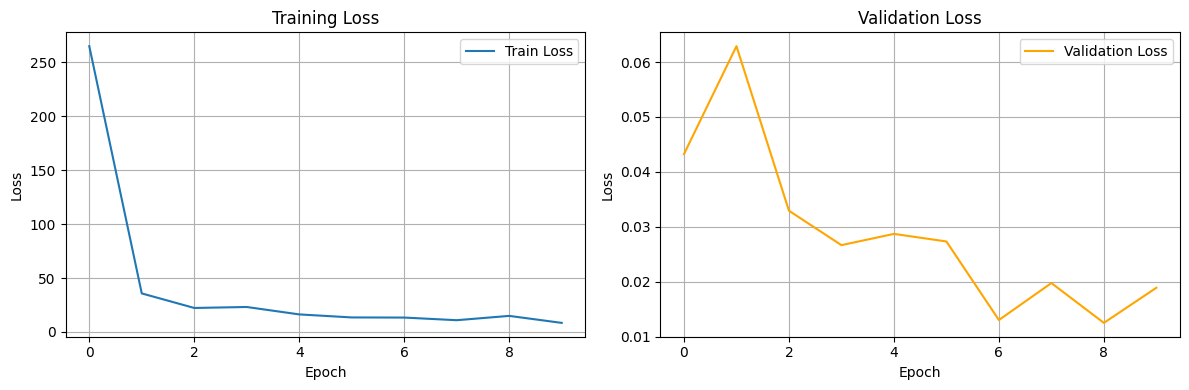

In [5]:
# 7. Training loop
for epoch in range(10):
    model.train()
    total_loss = 0

    for clips, labels in train_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        outputs = model(clips)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for clips, labels in val_loader:
            clips = clips.to(device)
            labels = labels.to(device)

            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(total_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch+1} with val loss: {avg_val_loss:.4f}")
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Training Loss
axs[0].plot(train_losses, label='Train Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].legend()
axs[0].grid(True)

# Validation Loss (in orange)
axs[1].plot(val_losses, label='Validation Loss', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### **Test Model & Evaluate Performance**
Load the best model, run inference on test data, and compute final loss and accuracy.

In [11]:
# 8. Inference Stage
state_dict = torch.load("best_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

test_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

# 9. Load test dataset
with open("dataset_splits.json", "r") as f:
    splits = json.load(f)
test_indices = splits["test"]

# 9-1. Convert indices to int (JSON converts keys to strings). we recall test_loader, because if we want to test our dataset after closing the jupyter
# notebook we need to redfine the test data set again and it may be mixed with the data, the algorithm was already trained by them.
test_indices = list(map(int, test_indices))
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        outputs = model(clips)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.0101, Test Accuracy: 99.75%


#### Building confusion matrix and calculate accuracy for each class

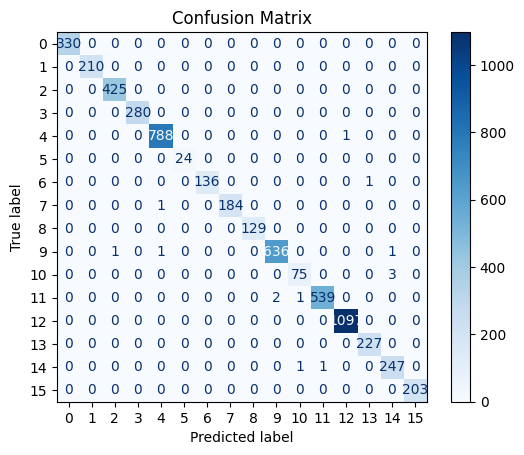

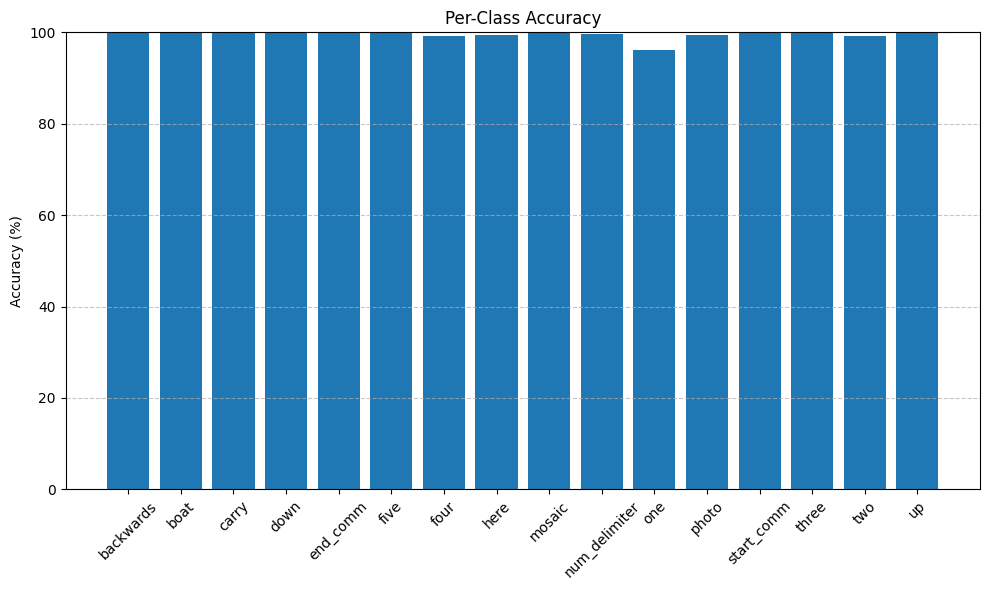

In [26]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_names = dataset.classes

# Plot bar chart of per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracy * 100)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Single Image Prediction**

In [10]:
# 9. guess the gesture
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

image_path = "biograd-A_00007_left.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)
input_tensor = input_tensor.to(device)

state_dict = torch.load("best_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = dataset.classes[predicted.item()]

print("Predicted gesture:", predicted_class)


Predicted gesture: five


### Assessing the robustness against noises and other modifications.
List of the changes are: Affine Distortion, Noise, Flip, Translation, Hue Shift

In [23]:
# === Helper: reverse normalization ===
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# === Define a cleaner noise function ===
def add_noise(pil_img, std=0.03):
    tensor_img = transforms.ToTensor()(pil_img)
    noisy = tensor_img + std * torch.randn_like(tensor_img)
    noisy = torch.clamp(noisy, 0, 1)
    return transforms.ToPILImage()(noisy)

# === Define augmentations ===
augmentations = {
    "original": lambda x: x,
    "flip": transforms.RandomHorizontalFlip(p=1.0),
    "affine": transforms.RandomAffine(degrees=25, shear=10),
    "hue": transforms.ColorJitter(hue=0.5),
    "translate": transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    "noise": lambda x: add_noise(x, std=0.03)
}

# === Load test dataset ===
with open("dataset_splits.json", "r") as f:
    splits = json.load(f)
test_indices = list(map(int, splits["test"]))
test_dataset = Subset(dataset, test_indices)

# === Save folder ===
save_root = "augmented_test_images"
os.makedirs(save_root, exist_ok=True)

# === Loop and save ===
mean = [0.5] * 3
std = [0.5] * 3

for i in range(len(test_dataset)):
    img_tensor, label = test_dataset[i]
    label_name = dataset.classes[label]

    # Denormalize to [0, 1] before converting
    img_tensor = denormalize(img_tensor.clone(), mean, std)
    pil_img = transforms.ToPILImage()(img_tensor)

    for aug_name, aug in augmentations.items():
        augmented = aug(pil_img)
        out_dir = os.path.join(save_root, aug_name, label_name)
        os.makedirs(out_dir, exist_ok=True)
        
        out_path = os.path.join(out_dir, f"{i}.png")
        augmented.save(out_path)

In [27]:
# --- 1. Setup ---
aug_root = "augmented_test_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your test-time transform (same as training/test preprocessing)
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Make sure model is in eval mode
state_dict = torch.load("best_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# --- 2. Loop through each augmentation folder ---
results = {}

for aug_name in sorted(os.listdir(aug_root)):
    aug_path = os.path.join(aug_root, aug_name)
    if not os.path.isdir(aug_path):
        continue  # skip non-folder files

    # Load dataset from folder
    aug_dataset = datasets.ImageFolder(root=aug_path, transform=transform)
    aug_loader = DataLoader(aug_dataset, batch_size=16, shuffle=False)

    # Evaluate
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in aug_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total if total > 0 else 0
    results[aug_name] = accuracy
    print(f"{aug_name:>10} accuracy: {accuracy:.2f}%")

    affine accuracy: 82.22%
      flip accuracy: 41.79%
       hue accuracy: 90.80%
     noise accuracy: 98.72%
  original accuracy: 99.75%
 translate accuracy: 95.78%
